#### 书上的例子

##### 1.简化版SMO算法处理小规模数据集

In [1]:
!ls datasets/

datingTestSet.txt  horseColicTest.txt	   housing.tgz	svm_RBF2.txt
email		   horseColicTraining.txt  ml_svm1.txt	svm_RBF.txt
horse-colic.data   housing.csv		   play		testSet.txt


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
file_path = "datasets/svm.txt"


def load_datasets(file_path):
    data = pd.read_csv(file_path,
                       sep='\t',
                       header=None,
                       names=['x1', 'x2', 'y']).to_numpy()
    return data[:, :-1], data[:, -1]

In [3]:
X,y=load_datasets(file_path)
X,y

(array([[ 3.542485e+00,  1.977398e+00],
        [ 3.018896e+00,  2.556416e+00],
        [ 7.551510e+00, -1.580030e+00],
        [ 2.114999e+00, -4.466000e-03],
        [ 8.127113e+00,  1.274372e+00],
        [ 7.108772e+00, -9.869060e-01],
        [ 8.610639e+00,  2.046708e+00],
        [ 2.326297e+00,  2.652130e-01],
        [ 3.634009e+00,  1.730537e+00],
        [ 3.413670e-01, -8.949980e-01],
        [ 3.125951e+00,  2.932510e-01],
        [ 2.123252e+00, -7.835630e-01],
        [ 8.878350e-01, -2.797792e+00],
        [ 7.139979e+00, -2.329896e+00],
        [ 1.696414e+00, -1.212496e+00],
        [ 8.117032e+00,  6.234930e-01],
        [ 8.497162e+00, -2.666490e-01],
        [ 4.658191e+00,  3.507396e+00],
        [ 8.197181e+00,  1.545132e+00],
        [ 1.208047e+00,  2.131000e-01],
        [ 1.928486e+00, -3.218700e-01],
        [ 2.175808e+00, -1.452700e-02],
        [ 7.886608e+00,  4.617550e-01],
        [ 3.223038e+00, -5.523920e-01],
        [ 3.628502e+00,  2.190585e+00],


In [26]:
X.dtype

dtype('float64')

In [21]:
def select_j_rand(i, length):
    """
        i α的下标
        length α的乘子的长度，即特征
        只有函数值不等于输入值i,需要重新选择j
    """
    j = i
    while (j == i):
        j = int(np.random.uniform(0, length))
    return j

In [42]:
select_j_rand(2,5)

i= 2
j= 2
j= 2


4

In [25]:
def clip_alpha(aj, H, L):
    """
         L<=aj<=H
         确保aj在L和H的上下界中
    """
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj

In [6]:
def smo_simple(X, y, C, toler, max_iter):
    """
        X: 特征值
        y: 标签值
        C： 常量
        toler：容错率，松弛变量
        max_iter：最大迭代次数
    """

    X = np.mat(X)
    y = np.mat(y).transpose()
    b = 0
    m, n = X.shape
    alphas = np.mat(np.zeros((m, 1)))  # X*1
    iter_i = 0
    
    while iter_i < max_iter:

        # alpha flag
        alpha_pairs_changed = 0
        for i in range(m):
            # f(x)=ω^T*x+b
            f_xi = np.multiply(alphas, y).T * (X * X[i, :].T) + b
            # loss E
            Ei = f_xi - float(y[i])
            # if checks  0<=α<=C and |yi*Ei|<toler
            # if an example violates KKT conditions
            if (y[i] * Ei < -toler and alphas[i] < C) or (y[i] * Ei > toler
                                                          and alphas[i] > 0):
                # select α2 by random
                j = select_j_rand(i, m)
                
                f_xj = np.multiply(alphas, y).T * (X * X[j, :].T) + b
                Ej = f_xj - float(y[j])
                alphai_old = alphas[i].copy()
                alphaj_old = alphas[j].copy()
                if y[i] != y[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L == H:
                    print("L==H ->", end="")
                    continue
                # η=K(xi,xi)+K(xj,xj)-2K(x1,x2)
                eta = 2.0 * X[i, :] * X[j, :].T - X[i, :] * X[i, :].T - X[
                    j, :] * X[j, :].T
                if eta >= 0:
                    print("eta>=0 ->", end="")
                    continue
                alphas[j] -= y[j] * (Ei - Ej) / eta
                alphas[j] = clip_alpha(alphas[j], H, L)
                if abs(alphas[j] - alphaj_old) < 1e-05:
                    print("j not moving enough ->", end="")
                    continue
                #update i by the same amount as j
                #the update is in the oppostie direction
                alphas[i] += y[j] * y[i] * (alphaj_old - alphas[j])
                b1 = b - Ei - y[i] * (
                    alphas[i] - alphai_old) * X[i, :] * X[i, :].T - y[j] * (
                        alphas[j] - alphaj_old) * X[i, :] * X[j, :].T
                b2 = b - Ej - y[i] * (
                    alphas[i] - alphai_old) * X[i, :] * X[j, :].T - y[j] * (
                        alphas[j] - alphaj_old) * X[j, :] * X[j, :].T
                # ktt as b
                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2.0
                alpha_pairs_changed += 1
                print("iter_i:%d i:%d, pairs changed %d ->" %
                      (iter_i, i, alpha_pairs_changed),
                      end="")
        iter_i = iter_i + 1 if alpha_pairs_changed == 0 else 0
        print("iter_iation number:%d" % iter_i)
        print("\n")
    return b, alphas

In [7]:
%%time
b,alphas=smo_simple(X,y,0.6,0.001,40)

iter_i:0 i:0, pairs changed 1 ->L==H ->L==H ->j not moving enough ->L==H ->L==H ->L==H ->j not moving enough ->iter_i:0 i:23, pairs changed 2 ->j not moving enough ->iter_i:0 i:26, pairs changed 3 ->j not moving enough ->iter_i:0 i:46, pairs changed 4 ->L==H ->iter_i:0 i:55, pairs changed 5 ->j not moving enough ->iter_iation number:0


j not moving enough ->L==H ->j not moving enough ->j not moving enough ->j not moving enough ->L==H ->j not moving enough ->j not moving enough ->iter_i:0 i:52, pairs changed 1 ->j not moving enough ->iter_i:0 i:62, pairs changed 2 ->L==H ->iter_i:0 i:82, pairs changed 3 ->iter_iation number:0


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->L==H ->j not moving enough ->iter_i:0 i:52, pairs changed 1 ->iter_i:0 i:54, pairs changed 2 ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:0


j not moving enough ->j not moving enough ->iter_i:0 i:26, pairs chang



j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_i:1 i:55, pairs changed 1 ->iter_i:1 i:76, pairs changed 2 ->L==H ->L==H ->iter_iation number:0


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->L==H ->j not moving enough ->j not moving enough ->iter_i:0 i:52, pairs changed 1 ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:0


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_i:0 i:54, pairs changed 1 ->j not moving enough ->j not moving enough ->iter_iation number:0


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_i:0 i:52, pairs changed 1 ->j not moving enough ->iter_i:0 i:55, pairs changed 2 ->j not moving enough ->iter_iation number:0


j not moving enough ->j not moving enough ->j not

j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:4


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:5


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:6


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:7


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_i

j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:3


j not moving enough ->j not moving enough ->j not moving enough ->iter_i:3 i:54, pairs changed 1 ->j not moving enough ->iter_iation number:0


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:1


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:2


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:3


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:4


j not moving enough ->j not moving enough ->j not moving enough ->j not moving enough ->iter_iation number:5


j not moving enough ->j not moving enough ->j not moving enough ->iter_i:5 i:55, pairs changed 1 ->iter_iation number:0


j not moving enough ->L==H ->j not moving enough ->j not moving enou

In [8]:
b,alphas[alphas>0]
#(matrix([[-3.80031322]]),
#matrix([[0.11130811, 0.25154614, 0.0184249 , 0.34442935]]))

(matrix([[-3.76165995]]),
 matrix([[0.0547535 , 0.29666398, 0.07945925, 0.27195822]]))

In [15]:
m,n=X.shape

In [16]:
# 支持向量的点
supoort_point=[(X[i],y[i]) for i in range(m) if alphas[i]>0 ]
supoort_point

[(array([4.658191, 3.507396]), -1.0),
 (array([ 3.457096, -0.082216]), -1.0),
 (array([ 5.286862, -2.358286]), 1.0),
 (array([6.080573, 0.418886]), 1.0)]

In [78]:
sns.set_style("whitegrid")


def plot_svm(X, y, w, b):
    plt.scatter(X[y == -1, 0],
                X[y == -1, 1],
                color='red',
                marker='o',
                label='TYPE_-1')
    plt.scatter(X[y == 1, 0],
                X[y == 1, 1],
                color='blue',
                marker='x',
                label='TYPE_1')
    for i in range(m):
        if alphas[i] > 0:

            plt.text(X[i][0],
                     X[i][1],
                     's',
                     family='serif',
                     style='italic',
                     ha='right',
                     wrap=True)
    #y= 画分割超平面 ??
    x = np.arange(-2, 7.0, 0.1)
    f_x = (-b[0, 0] * x) - 10 / np.linalg.norm(w)
    plt.plot(x, f_x)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='upper left')

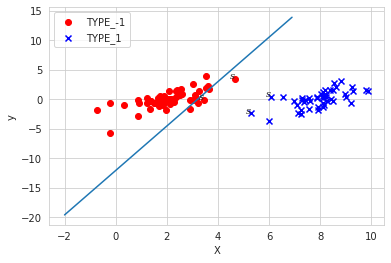

In [79]:
plot_svm(X,y,calc_w(alphas,X,y),b)

##### 优化SVM
1. α2选取max|Ei-Ej|,使用一个cache matrix 存储，然后选择max

In [36]:
def kernel_trans(X, A, k_tup):
    """
    calc the kernel or transform data to a higher dimensional space
    """
    m, n = X.shape
    K = np.mat(np.zeros((m, 1)))
    if k_tup[0] == 'lin':
        #linear kernel
        K = X * A.T
    elif k_tup[0] == 'rbf':
        for j in range(m):
            delta_row = X[j, :] - A
            K[j] = delta_row * delta_row.T
        #divide in NumPy is element-wise not matrix like Matlab
        K = np.exp(K / (-1 * k_tup[1]**2))
    else:
        raise NameError(
            'Houston We Have a Problem -- That Kernel is not recognized')
    return K 

In [40]:
class svm_struct():
    """
       init svm struct
    """
    def __init__(self, X, y, C, toler, k_tup):
        self.X = X  #
        self.y = y
        self.C = C
        self.toler = toler
        self.m = X.shape[0]
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        # valid flag,Ei
        self.Ecache = np.mat(np.zeros((self.m, 2)))
        # add kernel
        self.K = np.mat(np.zeros((self.m, self.m)))
        for i in range(self.m):
            self.K[:, i] = kernel_trans(self.X, self.X[i, :], k_tup)

In [43]:
def calc_Ek(struct, k):
    """
     calculate Ek=F(Xk)-yk
    """
    f_xk = np.multiply(struct.alphas,
                       struct.y).T * (struct.X * struct.X[k, :].T) + struct.b
    return f_xk - struct.y[k]

In [22]:
def select_j(i, struct, Ei):
    """
      启发式方法选择α2，选择最大步长的j，即max|Ei-Ej|
    """
    max_k = -1
    max_delta_E = 0
    Ej = 0
    struct.Ecache[i] = [1, Ei]
    valid_Ecache_list = np.nonzero(struct.Ecache[:, 0].A)[0]
    if len(valid_Ecache_list) > 1:
        for k in valid_Ecache_list:
            if k == i:
                continue
            Ek = calc_Ek(struct, k)
            delta_E = abs(Ei - Ek)
            if delta_E > max_delta_E:
                # update E
                max_k = k
                max_delta_E = delta_E
                Ej = Ek
        return max_k, Ej
    else:
        # in this case (first time around) we don't have any valid eCache values
        # first iter ,select random α2
        j = select_j_rand(i, struct.m)
        Ej = calc_Ek(struct, j)
    return j, Ej

In [24]:
def update_Ek(struct, k):
    """
    after any alpha has changed update the new value in the cache
    """
    Ek = calc_Ek(struct, k)
    struct.Ecache[k] = [1, Ek]

In [27]:
#as smo_simple
def inner_L(i, struct):
    Ei = calc_Ek(struct, i)
    if (struct.y[i] * Ei < -struct.toler and struct.alphas[i] < struct.C) or (
            struct.y[i] * Ei > struct.toler and struct.alphas[i] > 0):
        # not random ,but by Ei
        j, Ej = select_j(i, struct, Ei)
        alphai_old = struct.alphas[i].copy()
        alphaj_old = struct.alphas[j].copy()
        if struct.y[i] != struct.y[j]:
            L = max(0, struct.alphas[j] - struct.alphas[i])
            H = min(struct.C, struct.C + struct.alphas[j] - struct.alphas[i])
        else:
            L = max(0, struct.alphas[j] + struct.alphas[i] - struct.C)
            H = min(struct.C, struct.alphas[j] + struct.alphas[i])
        if L == H:
            print("L==H")
            return 0
        #changed for kernel
        eta = 2.0 * struct.K[i, j] - struct.K[i, i] - struct.K[j, j]
        if eta >= 0:
            print("eta>=0")
            return 0
        struct.alphas[j] -= struct.y[j] * (Ei - Ej) / eta

        struct.alphas[j] = clip_alpha(struct.alphas[j], H, L)
        #added this for the Ecache
        update_Ek(struct, j)
        if abs(struct.alphas[j] - alphaj_old) < 1e-05:
            print("j not moving enough")
            return 0
        #update i by the same amount as j
        #the update is in the oppstructtie direction
        struct.alphas[i] += struct.y[j] * struct.y[i] * (alphaj_old -
                                                         struct.alphas[j])
        #added this for the Ecache
        update_Ek(struct, i)
        b1 = struct.b - Ei - struct.y[i] * (
            struct.alphas[i] - alphai_old) * struct.K[i, i] - struct.y[j] * (
                struct.alphas[j] - alphaj_old) * struct.K[i, j]
        b2 = struct.b - Ej - struct.y[i] * (
            struct.alphas[i] - alphai_old) * struct.K[i, j] - struct.y[j] * (
                struct.alphas[j] - alphaj_old) * struct.K[j, j]
        if 0 < struct.alphas[i] < struct.C:
            struct.b = b1
        elif 0 < struct.alphas[i] < struct.C:
            struct.b = b2
        else:
            struct.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0

In [41]:
def smo_platt(X, y, C, toler, max_iter, k_tup=('lin', 0)):
    struct = svm_struct(np.mat(X), np.mat(y).transpose(), C, toler, k_tup)
    iter_i = 0
    entire_set = True
    alpha_pairs_changed = 0
    while iter_i < max_iter and (alpha_pairs_changed > 0 or entire_set):
        alpha_pairs_changed = 0
        if entire_set:
            #go over all
            for i in range(struct.m):
                alpha_pairs_changed += inner_L(i, struct)
                print("fullSet, iter: %d i:%d, pairs changed %d" %
                      (iter_i, i, alpha_pairs_changed))
            iter_i += 1
        else:
            #go over non-bound (railed) alphas
            nonbounds_i = np.nonzero(
                (struct.alphas.A > 0) * (struct.alphas.A < C))[0]
            for i in nonbounds_i:
                alpha_pairs_changed += inner_L(i, struct)
                print("non-bound, iter: %d i:%d, pairs changed %d" %
                      (iter_i, i, alpha_pairs_changed))
            iter_i += 1
        if entire_set:
            #toggle entire set loop
            entire_set = False
        elif alpha_pairs_changed == 0:
            entire_set = True
        print("iteration number: %d" % iter_i)
    return struct.b, struct.alphas

In [46]:
%%time 
# 7379 ms
smo_platt_b, smo_platt_alphas = smo_platt(X, y, 0.6, 0.001, 40)

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 1
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 1
fullSet, iter: 0 i:5, pairs changed 1
fullSet, iter: 0 i:6, pairs changed 1
fullSet, iter: 0 i:7, pairs changed 1
fullSet, iter: 0 i:8, pairs changed 2
fullSet, iter: 0 i:9, pairs changed 2
fullSet, iter: 0 i:10, pairs changed 3
fullSet, iter: 0 i:11, pairs changed 3
fullSet, iter: 0 i:12, pairs changed 3
fullSet, iter: 0 i:13, pairs changed 3
fullSet, iter: 0 i:14, pairs changed 3
fullSet, iter: 0 i:15, pairs changed 3
fullSet, iter: 0 i:16, pairs changed 3
fullSet, iter: 0 i:17, pairs changed 4
fullSet, iter: 0 i:18, pairs changed 4
fullSet, iter: 0 i:19, pairs changed 4
fullSet, iter: 0 i:20, pairs changed 4
fullSet, iter: 0 i:21, pairs changed 4
fullSet, iter: 0 i:22, pairs changed 4
fullSet, iter: 0 i:23, pairs changed 5
fullSet, iter: 0 i:24, pairs changed 5
fullSet, iter: 0 i:25, pairs change

In [86]:
smo_platt_b, smo_platt_alphas[smo_platt_alphas>0]

(matrix([[-2.99262986]]),
 matrix([[0.00692341, 0.09718385, 0.03450221, 0.02312016, 0.06374615,
          0.06374615, 0.20418402, 0.04245439]]))

In [ ]:
def calc_w(alphas, X, y):
    """
     ω=Σαiyixi
    """
    X = np.mat(X)
    y = np.mat(y).transpose()
    m, n = X.shape
    return sum(np.multiply(alphas[i] * y[i], X[i, :].T) for i in range(m))

In [85]:
w=calc_w(smo_platt_alphas,X,y)
w

matrix([[ 0.67037728],
        [-0.19969184]])

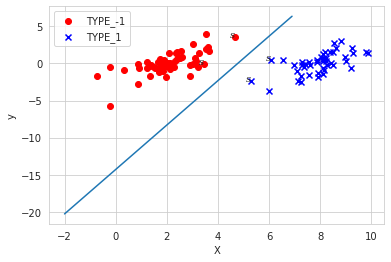

In [87]:
plot_svm(X,y,w,smo_platt_b)

In [50]:
!ls datasets/

datingTestSet.txt  horseColicTest.txt	   housing.tgz	 svm_RBF.txt
email		   horseColicTraining.txt  play		 svm.txt
horse-colic.data   housing.csv		   svm_RBF2.txt  testSet.txt


In [51]:
rbf_X,rbf_y=load_datasets("datasets/svm_RBF.txt")
rbf_X,rbf_y

(array([[-2.14824e-01,  6.62756e-01],
        [-6.15690e-02, -9.18750e-02],
        [ 4.06933e-01,  6.48055e-01],
        [ 2.23650e-01,  1.30142e-01],
        [ 2.31317e-01,  7.66906e-01],
        [-7.48800e-01, -5.31637e-01],
        [-5.57789e-01,  3.75797e-01],
        [ 2.07123e-01, -1.94630e-02],
        [ 2.86462e-01,  7.19470e-01],
        [ 1.95300e-01, -1.79039e-01],
        [-1.52696e-01, -1.53030e-01],
        [ 3.84471e-01,  6.53336e-01],
        [-1.17280e-01, -1.53217e-01],
        [-2.38076e-01,  5.83000e-04],
        [-4.13576e-01,  1.45681e-01],
        [ 4.90767e-01, -6.80029e-01],
        [ 1.99894e-01, -1.99381e-01],
        [-3.56048e-01,  5.37960e-01],
        [-3.92868e-01, -1.25261e-01],
        [ 3.53588e-01, -7.06170e-02],
        [ 2.09840e-02,  9.25720e-01],
        [-4.75167e-01, -3.46247e-01],
        [ 7.49520e-02,  4.27830e-02],
        [ 3.94164e-01, -5.82170e-02],
        [ 6.63418e-01,  4.36525e-01],
        [ 4.02158e-01,  5.77744e-01],
        [-4.

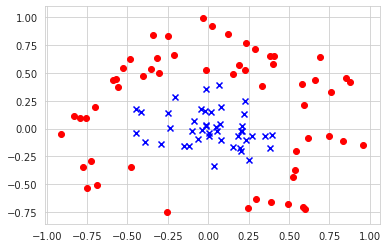

In [52]:
plt.scatter(rbf_X[rbf_y == -1, 0],
            rbf_X[rbf_y == -1, 1],
            color='red',
            marker='o',
            label='TYPE_-1')
plt.scatter(rbf_X[rbf_y == 1, 0],
            rbf_X[rbf_y == 1, 1],
            color='blue',
            marker='x',
            label='TYPE_1')

#### 核函数